In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
# import optuna  # Import Optuna for hyperparameter tuning
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
import sys
import nltk
import ssl
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import torch.nn.functional as F

In [2]:
# Fix SSL issue for NLTK
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download NLTK dependencies
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/elvin12e/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/elvin12e/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/elvin12e/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/elvin12e/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/elvin12e/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
notebook_dir = os.getcwd()
project_dir = os.path.dirname(notebook_dir)
project_dir = os.path.dirname(project_dir)
sys.path.append(project_dir)
print(os.listdir(project_dir))


from data import preprocess, feature_extraction
from visualization import visualize


['visualization', 'hyperparameter_tunning', 'features', 'models', 'data', '__init__.py']


In [4]:
# Step 1: Load and preprocess the data
pre_proc = preprocess.Preprocessing()
df = pre_proc.read_CSV('train.csv')

# Ensure the column names exist
if 'text' not in df.columns or 'sentiment' not in df.columns:
    raise ValueError("Error: Columns 'text' or 'sentiment' not found in CSV file.")

# Preprocess text
df['text'] = df['text'].fillna("")  # Ensure no NaN values
texts = df['text'].apply(pre_proc.preprocess)
labels = df['sentiment'].values  # Labels

# Convert Labels to Numeric
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Custom Linear Support Vector Machine from Scratch (With PCA code from scratch)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/elvin12e/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/elvin12e/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/elvin12e/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/elvin12e/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Class Distribution:
 sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64
Class Weights: {0: np.float64(1.177226577560725), 1: np.float64(0.8239632994512908), 2: np.float64(1.0673502680027966)}
Applying Custom PCA to retain 90% variance...
Number of components: 2878
Explained variance ratio: 0.9000
Training OvR SVM...
Training complete.
Validation Accuracy: 0.6249393498301795
Validation Classification Report:
               precision    recall  f1-score   support

    negative       0.61      0.61      0.61      1167
     neutral       0.58      0.67      0.62      1668
    positive       0.73      0.57      0.64      1287

    accuracy                           0.62      4122
   macro avg       0.64      0.62      0.63      4122
weighted avg       0.63      0.62      0.63      4122

Validation F1-Score: 0.625389856894219


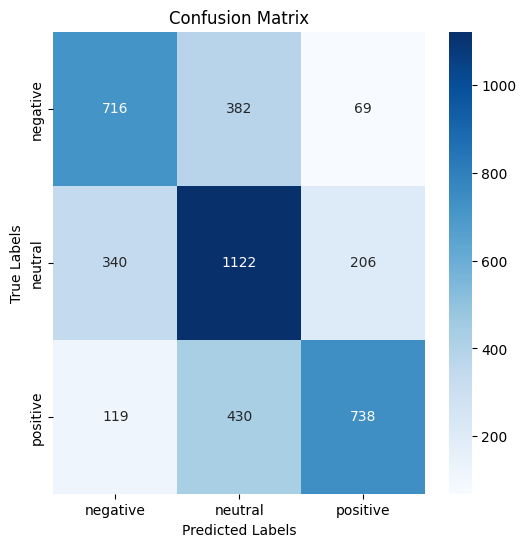

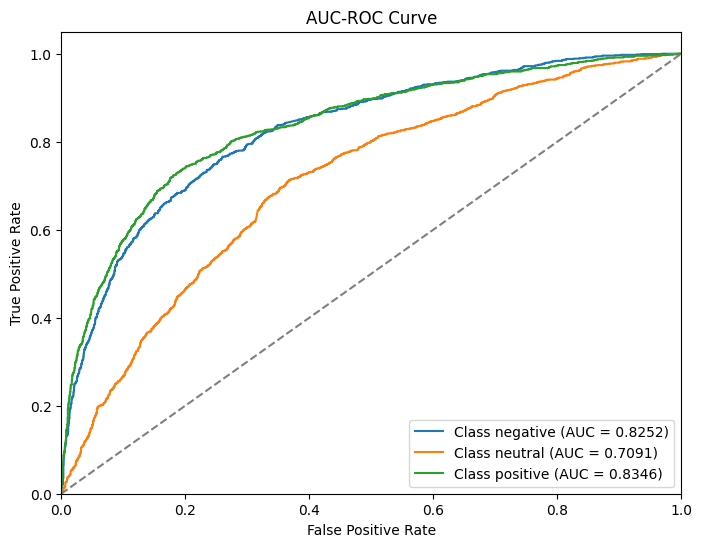


Test.csv Predictions (First 5 rows):
       textID                                               text  \
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   
1  96d74cb729   Shanghai is also really exciting (precisely -...   
2  eee518ae67  Recession hit Veronique Branquinho, she has to...   
3  01082688c6                                        happy bday!   
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!   

  predicted_sentiment  
0            positive  
1            positive  
2             neutral  
3            positive  
4            negative  

Predictions saved to test_predictions.csv


In [10]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import nltk

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# ----------- Custom PCA Implementation -----------
class CustomPCA:
    def __init__(self, n_components=None, variance_ratio=None):
        self.n_components = n_components
        self.variance_ratio = variance_ratio
        self.components_ = None
        self.mean_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.n_components_ = None

    def fit(self, X):
        """Fit PCA on the training data."""
        # Center the data
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        # Compute covariance matrix
        covariance_matrix = np.cov(X_centered.T)

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Store explained variance
        self.explained_variance_ = eigenvalues
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio_ = eigenvalues / total_variance

        # Determine number of components
        if self.variance_ratio is not None:
            cumulative_variance = np.cumsum(self.explained_variance_ratio_)
            self.n_components_ = np.argmax(cumulative_variance >= self.variance_ratio) + 1
        else:
            self.n_components_ = self.n_components or X.shape[1]

        # Select top components
        self.components_ = eigenvectors[:, :self.n_components_]

        return self

    def transform(self, X):
        """Transform data using the fitted PCA."""
        X_centered = X - self.mean_
        return np.dot(X_centered, self.components_)

    def fit_transform(self, X):
        """Fit PCA and transform the data."""
        return self.fit(X).transform(X)

# ----------- Linear SVM with Improved Class Weighting -----------
class LinearSVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.001, n_iters=5000, class_weight=None):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.class_weight = class_weight or {1: 1.0, -1: 1.0}
        self.w = None
        self.b = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                weight = self.class_weight[y[idx]]
                condition = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    dw = 2 * self.lambda_param * self.w
                    db = 0
                else:
                    dw = 2 * self.lambda_param * self.w - weight * np.dot(x_i, y[idx])
                    db = -weight * y[idx]
                self.w -= self.lr * dw
                self.b -= self.lr * db
    
    def decision_function(self, X):
        return np.dot(X, self.w) - self.b

    def predict(self, X):
        return np.sign(self.decision_function(X))

# ----------- Multi-Class SVM (One-vs-Rest) with Score Normalization -----------
class OvRLinearSVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.001, n_iters=5000, class_weights=None):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.class_weights = class_weights
        self.classifiers = {}
        self.classes = None
        self.score_stats = {}
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            y_binary = np.where(y == cls, 1, -1)
            weights = {1: self.class_weights.get(cls, 1.0), -1: 1.0}
            svm = LinearSVM(self.lr, self.lambda_param, self.n_iters, weights)
            svm.fit(X, y_binary)
            self.classifiers[cls] = svm
            scores = svm.decision_function(X)
            self.score_stats[cls] = (np.mean(scores), np.std(scores) + 1e-8)
    
    def predict(self, X):
        scores = np.zeros((X.shape[0], len(self.classes)))
        for idx, cls in enumerate(self.classes):
            scores[:, idx] = self.classifiers[cls].decision_function(X)
            mean, std = self.score_stats[cls]
            scores[:, idx] = (scores[:, idx] - mean) / std
        return self.classes[np.argmax(scores, axis=1)]
    
    def decision_function(self, X):
        scores = np.zeros((X.shape[0], len(self.classes)))
        for idx, cls in enumerate(self.classes):
            scores[:, idx] = self.classifiers[cls].decision_function(X)
            mean, std = self.score_stats[cls]
            scores[:, idx] = (scores[:, idx] - mean) / std
        scores = 1 / (1 + np.exp(-scores))
        return scores

def main():
    # Initialize preprocessing
    pre_proc = preprocess.Preprocessing()

    # Load train data
    df = pre_proc.read_CSV('train.csv')
    if 'text' not in df.columns or 'sentiment' not in df.columns:
        raise ValueError("CSV must contain 'text' and 'sentiment' columns")

    # Fill missing texts
    df['text'] = df['text'].fillna("")

    # Preprocess text
    df['processed_text'] = df['text'].apply(lambda x: pre_proc.preprocess(x, return_tokens=False))

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['sentiment'])
    class_labels = label_encoder.classes_  # ['negative', 'neutral', 'positive']

    # Check class distribution
    class_counts = df['sentiment'].value_counts()
    print("Class Distribution:\n", class_counts)
    total_samples = len(df)
    class_weights = {i: total_samples / (len(class_labels) * class_counts[class_labels[i]]) 
                     for i in range(len(class_labels))}
    print("Class Weights:", class_weights)

    # Extract TF-IDF features
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5)
    X = vectorizer.fit_transform(df['processed_text']).toarray()

    # Apply Custom PCA
    pca = CustomPCA(variance_ratio=0.9)  # Retain 90% variance
    print("Applying Custom PCA to retain 90% variance...")
    X_pca = pca.fit_transform(X)
    print(f"Number of components: {pca.n_components_}")
    print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_[:pca.n_components_]):.4f}")

    # Split train.csv into train (85%) and validation (15%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_pca, y, test_size=0.15, random_state=42, stratify=y)

    # Initialize and train OvR SVM
    svm = OvRLinearSVM(learning_rate=0.01, lambda_param=0.001, n_iters=5000, 
                       class_weights=class_weights)
    print("Training OvR SVM...")
    svm.fit(X_train, y_train)
    print("Training complete.")

    # Validate
    val_preds = svm.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, val_preds))
    print("Validation Classification Report:\n", 
          classification_report(y_val, val_preds, target_names=class_labels))
    print("Validation F1-Score:", visualize.compute_f1_score(y_val, val_preds))
    visualize.plot_confusion_matrix(y_val, val_preds, class_labels)

    # Plot ROC-AUC
    y_pred_probs = svm.decision_function(X_val)
    visualize.plot_roc_auc(y_val, y_pred_probs, class_labels)

    # Load and preprocess test.csv
    df_test = pre_proc.read_CSV('test.csv')
    df_test['text'] = df_test['text'].fillna("")
    df_test['processed_text'] = df_test['text'].apply(lambda x: pre_proc.preprocess(x, return_tokens=False))
    X_test_new = vectorizer.transform(df_test['processed_text']).toarray()
    X_test_new_pca = pca.transform(X_test_new)

    # Predict sentiments for test.csv
    test_preds_new = svm.predict(X_test_new_pca)
    test_preds_labels = label_encoder.inverse_transform(test_preds_new)

    # Add predictions to DataFrame
    df_test['predicted_sentiment'] = test_preds_labels
    print("\nTest.csv Predictions (First 5 rows):")
    print(df_test[['textID', 'text', 'predicted_sentiment']].head())

    # Save predictions to CSV
    output_path = 'test_predictions.csv'
    df_test[['textID', 'predicted_sentiment']].to_csv(output_path, index=False)
    print(f"\nPredictions saved to {output_path}")

if __name__ == '__main__':
    main()

# Custom Kernel SVM (run slow if you do not have powerful CPU - almost 12 hours)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# ----------- Text Preprocessing -----------
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

# ----------- Kernel SVM from scratch -----------
class KernelSVM:
    def __init__(self, C=1.0, kernel='rbf', gamma=0.1, tol=1e-3, max_iter=100):
        self.C = C  # Regularization parameter
        self.kernel = kernel
        self.gamma = gamma  # RBF kernel parameter
        self.tol = tol  # Tolerance for stopping criteria
        self.max_iter = max_iter
        self.alphas = None
        self.b = None
        self.support_vectors = None
        self.support_labels = None
        self.X_train = None

    def rbf_kernel(self, x1, x2):
        """Compute RBF (Gaussian) kernel between x1 and x2."""
        if x1.ndim == 1:
            x1 = x1.reshape(1, -1)
        if x2.ndim == 1:
            x2 = x2.reshape(1, -1)
        diff = np.sum((x1 - x2) ** 2, axis=1)
        return np.exp(-self.gamma * diff)

    def kernel_matrix(self, X1, X2):
        """Compute kernel matrix between X1 and X2."""
        n1 = X1.shape[0]
        n2 = X2.shape[0]
        K = np.zeros((n1, n2))
        for i in range(n1):
            for j in range(n2):
                K[i, j] = self.rbf_kernel(X1[i], X2[j])
        return K

    def fit(self, X, y):
        """Train Kernel SVM using a simplified SMO algorithm."""
        n_samples, n_features = X.shape
        self.X_train = X
        self.alphas = np.zeros(n_samples)
        self.b = 0
        self.support_vectors = X
        self.support_labels = y

        # Compute kernel matrix
        K = self.kernel_matrix(X, X)

        # Simplified SMO
        passes = 0
        while passes < self.max_iter:
            num_changed_alphas = 0
            for i in range(n_samples):
                Ei = self.decision_function(X[i]) - y[i]
                if (y[i] * Ei < -self.tol and self.alphas[i] < self.C) or \
                   (y[i] * Ei > self.tol and self.alphas[i] > 0):
                    # Select j != i randomly
                    j = np.random.choice([k for k in range(n_samples) if k != i])
                    Ej = self.decision_function(X[j]) - y[j]

                    # Save old alphas
                    alpha_i_old = self.alphas[i]
                    alpha_j_old = self.alphas[j]

                    # Compute L and H (bounds for alpha_j)
                    if y[i] != y[j]:
                        L = max(0, self.alphas[j] - self.alphas[i])
                        H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
                    else:
                        L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                        H = min(self.C, self.alphas[i] + self.alphas[j])

                    if L == H:
                        continue

                    # Compute eta
                    eta = 2 * K[i, j] - K[i, i] - K[j, j]
                    if eta >= 0:
                        continue

                    # Update alpha_j
                    self.alphas[j] -= y[j] * (Ei - Ej) / eta
                    self.alphas[j] = max(L, min(H, self.alphas[j]))

                    if abs(self.alphas[j] - alpha_j_old) < 1e-5:
                        continue

                    # Update alpha_i
                    self.alphas[i] += y[i] * y[j] * (alpha_j_old - self.alphas[j])

                    # Update bias b
                    b1 = self.b - Ei - y[i] * (self.alphas[i] - alpha_i_old) * K[i, i] - \
                         y[j] * (self.alphas[j] - alpha_j_old) * K[i, j]
                    b2 = self.b - Ej - y[i] * (self.alphas[i] - alpha_i_old) * K[i, j] - \
                         y[j] * (self.alphas[j] - alpha_j_old) * K[j, j]

                    if 0 < self.alphas[i] < self.C:
                        self.b = b1
                    elif 0 < self.alphas[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

                    num_changed_alphas += 1

            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0

        # Store support vectors
        sv_idx = self.alphas > 1e-5
        self.alphas = self.alphas[sv_idx]
        self.support_vectors = X[sv_idx]
        self.support_labels = y[sv_idx]

    def decision_function(self, X):
        """Compute decision function for input X."""
        if X.ndim == 1:
            X = X.reshape(1, -1)
        K = self.kernel_matrix(X, self.support_vectors)
        return np.sum(self.alphas * self.support_labels * K, axis=1) + self.b

    def predict(self, X):
        """Predict class labels for X."""
        return np.sign(self.decision_function(X))

# ----------- Main pipeline -----------
def main():
    # Load data from CSV
    pre_proc = preprocess.Preprocessing()
    df = pre_proc.read_CSV('train.csv')
    # df2 = pd.read_csv('test.csv')  # Commented out as it's not used

    if 'text' not in df.columns or 'sentiment' not in df.columns:
        raise ValueError("CSV must contain 'text' and 'sentiment' columns")

    # Fill missing texts
    df['text'] = df['text'].fillna("")

    # Preprocess text
    df['processed_text'] = df['text'].apply(preprocess_text)

    # Encode labels (e.g., positive=1, negative=0)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['sentiment'])

    # Extract TF-IDF features
    vectorizer = TfidfVectorizer(max_features=5000)
    X = vectorizer.fit_transform(df['processed_text'])

    # Split data: train 70%, val 15%, test 15%
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val)

    # Convert sparse matrices to dense arrays
    X_train = X_train.toarray()
    X_val = X_val.toarray()
    X_test = X_test.toarray()

    y_train_svm = np.where(y_train == 0, -1, 1)
    y_val_svm = np.where(y_val == 0, -1, 1)
    y_test_svm = np.where(y_test == 0, -1, 1)

    # Initialize and train Kernel SVM
    svm = KernelSVM(C=1.0, kernel='rbf', gamma=0.1, max_iter=100)
    print("Training Kernel SVM...")
    svm.fit(X_train, y_train_svm)
    print("Training complete.")

    # Validate
    val_preds = svm.predict(X_val)
    val_preds = np.where(val_preds == -1, 0, 1)

    print("Validation Accuracy:", accuracy_score(y_val, val_preds))
    print("Validation Classification Report:\n", classification_report(y_val, val_preds))

    # Test
    test_preds = svm.predict(X_test)
    test_preds = np.where(test_preds == -1, 0, 1)

    print("Test Accuracy:", accuracy_score(y_test, test_preds))
    print("Test Classification Report:\n", classification_report(y_test, test_preds))

if __name__ == '__main__':
    main()

# Kernel SVM using SVC library from scikit-learn

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/elvin12e/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/elvin12e/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/elvin12e/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/elvin12e/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Class Distribution:
 sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64
Class Weights: {0: np.float64(1.177226577560725), 1: np.float64(0.8239632994512908), 2: np.float64(1.0673502680027966)}
Applying Custom PCA to retain 90% variance...
Number of components: 2878
Explained variance ratio: 0.9000
Training SVC...
Training complete.
Validation Accuracy: 0.6887433284813197
Validation Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.65      0.67      1167
     neutral       0.63      0.71      0.67      1668
    positive       0.77      0.70      0.73      1287

    accuracy                           0.69      4122
   macro avg       0.70      0.69      0.69      4122
weighted avg       0.69      0.69      0.69      4122

Validation F1-Score: 0.6911857156553554


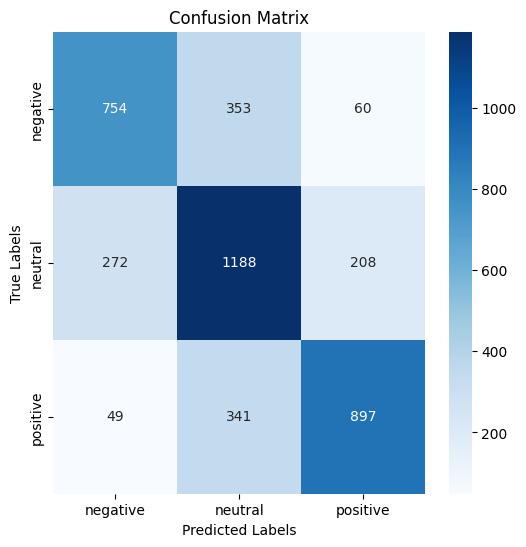

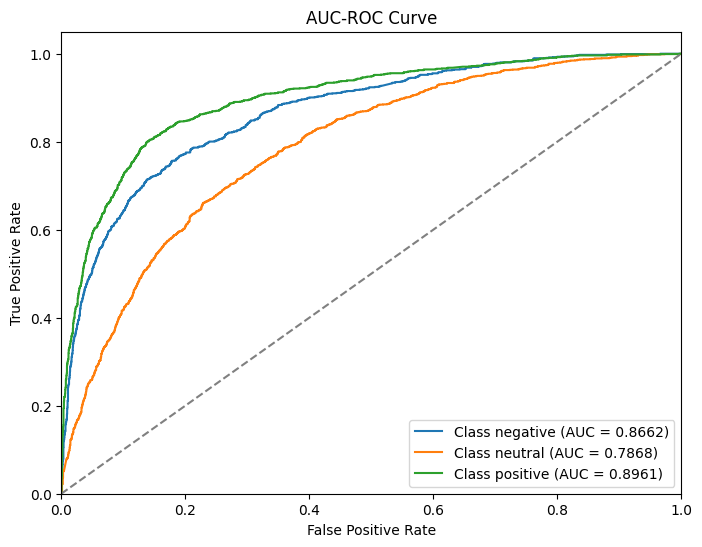


Test.csv Predictions (First 5 rows):
       textID                                               text  \
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   
1  96d74cb729   Shanghai is also really exciting (precisely -...   
2  eee518ae67  Recession hit Veronique Branquinho, she has to...   
3  01082688c6                                        happy bday!   
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!   

  predicted_sentiment  
0             neutral  
1            positive  
2             neutral  
3            positive  
4            positive  

Predictions saved to test_predictions.csv


In [9]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
import nltk

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# ----------- Custom PCA Implementation -----------
class CustomPCA:
    def __init__(self, n_components=None, variance_ratio=None):
        self.n_components = n_components
        self.variance_ratio = variance_ratio
        self.components_ = None
        self.mean_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.n_components_ = None

    def fit(self, X):
        """Fit PCA on the training data."""
        # Center the data
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        # Compute covariance matrix
        covariance_matrix = np.cov(X_centered.T)

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Store explained variance
        self.explained_variance_ = eigenvalues
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio_ = eigenvalues / total_variance

        # Determine number of components
        if self.variance_ratio is not None:
            cumulative_variance = np.cumsum(self.explained_variance_ratio_)
            self.n_components_ = np.argmax(cumulative_variance >= self.variance_ratio) + 1
        else:
            self.n_components_ = self.n_components or X.shape[1]

        # Select top components
        self.components_ = eigenvectors[:, :self.n_components_]

        return self

    def transform(self, X):
        """Transform data using the fitted PCA."""
        X_centered = X - self.mean_
        return np.dot(X_centered, self.components_)

    def fit_transform(self, X):
        """Fit PCA and transform the data."""
        return self.fit(X).transform(X)

def main():
    # Initialize preprocessing
    pre_proc = preprocess.Preprocessing()

    # Load train data
    df = pre_proc.read_CSV('train.csv')
    if 'text' not in df.columns or 'sentiment' not in df.columns:
        raise ValueError("CSV must contain 'text' and 'sentiment' columns")

    # Fill missing texts
    df['text'] = df['text'].fillna("")

    # Preprocess text
    df['processed_text'] = df['text'].apply(lambda x: pre_proc.preprocess(x, return_tokens=False))

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['sentiment'])
    class_labels = label_encoder.classes_  # ['negative', 'neutral', 'positive']

    # Check class distribution
    class_counts = df['sentiment'].value_counts()
    print("Class Distribution:\n", class_counts)
    total_samples = len(df)
    class_weights = {i: total_samples / (len(class_labels) * class_counts[class_labels[i]]) 
                     for i in range(len(class_labels))}
    print("Class Weights:", class_weights)

    # Extract TF-IDF features
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5)
    X = vectorizer.fit_transform(df['processed_text']).toarray()

    # Apply Custom PCA
    pca = CustomPCA(variance_ratio=0.9)  # Retain 90% variance
    print("Applying Custom PCA to retain 90% variance...")
    X_pca = pca.fit_transform(X)
    print(f"Number of components: {pca.n_components_}")
    print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_[:pca.n_components_]):.4f}")

    # Split train.csv into train (85%) and validation (15%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_pca, y, test_size=0.15, random_state=42, stratify=y)

    # Initialize and train SVC
    svm = SVC(kernel='rbf', class_weight=class_weights, probability=True, random_state=42)
    print("Training SVC...")
    svm.fit(X_train, y_train)
    print("Training complete.")

    # Validate
    val_preds = svm.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, val_preds))
    print("Validation Classification Report:\n", 
          classification_report(y_val, val_preds, target_names=class_labels))
    print("Validation F1-Score:", visualize.compute_f1_score(y_val, val_preds))
    visualize.plot_confusion_matrix(y_val, val_preds, class_labels)

    # Plot ROC-AUC
    y_pred_probs = svm.predict_proba(X_val)
    visualize.plot_roc_auc(y_val, y_pred_probs, class_labels)

    # Load and preprocess test.csv
    df_test = pre_proc.read_CSV('test.csv')
    df_test['text'] = df_test['text'].fillna("")
    df_test['processed_text'] = df_test['text'].apply(lambda x: pre_proc.preprocess(x, return_tokens=False))
    X_test_new = vectorizer.transform(df_test['processed_text']).toarray()
    X_test_new_pca = pca.transform(X_test_new)

    # Predict sentiments for test.csv
    test_preds_new = svm.predict(X_test_new_pca)
    test_preds_labels = label_encoder.inverse_transform(test_preds_new)

    # Add predictions to DataFrame
    df_test['predicted_sentiment'] = test_preds_labels
    print("\nTest.csv Predictions (First 5 rows):")
    print(df_test[['textID', 'text', 'predicted_sentiment']].head())

    # Save predictions to CSV
    output_path = 'test_predictions.csv'
    df_test[['textID', 'predicted_sentiment']].to_csv(output_path, index=False)
    print(f"\nPredictions saved to {output_path}")

if __name__ == '__main__':
    main()